<a href="https://colab.research.google.com/github/iyappan24/Applied-AI-Notebooks/blob/master/K_Nearest_Neighbours.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AMAZON FINE FOOD REVIEWS : POLARITY CLASSIFICATION USIGN K-NN

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

### Installing Libraries and Dependencies in Google Drive

In [2]:
!pip install gensim

    100% |████████████████████████████████| 23.6MB 1.4MB/s 
    100% |████████████████████████████████| 1.4MB 14.1MB/s 
    100% |████████████████████████████████| 133kB 27.8MB/s 
    100% |████████████████████████████████| 4.7MB 6.1MB/s 
    100% |████████████████████████████████| 61kB 22.2MB/s 
    100% |████████████████████████████████| 552kB 24.9MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
import nltk
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import sqlite3
import re
from datetime import datetime

--------------
##Mounting google drive to get the data from the google drive folder

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
con = sqlite3.connect('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/database.sqlite')

In [0]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)

In [9]:
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
def partition(x):
    if x < 3:
        return 0
    return 1

In [0]:
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [12]:
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [13]:
print("Number of data points in our data", filtered_data.shape)

Number of data points in our data (525814, 10)


** Removing the Duplicate entries ** 

In [0]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [15]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

## TEXT PRE-PROCESSING

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

** REMOVING HTML TAGS  and PUNCTUATIONS** 

In [0]:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [0]:
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

In [0]:
#removing not and no from list of stopwords 
stop.remove('not')
stop.remove('no')

In [21]:
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1
        
#############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()

100%|██████████| 364173/364173 [09:09<00:00, 662.48it/s]


In [0]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()

In [23]:
final.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...


In [24]:
!ls

final.sqlite  gdrive  sample_data


### DATA SAMPLING:

1. SORT BY TIME FIRST 
2. TAKING ALL THE POINTS IS NOT FEASIBLE FOR COMPUTATION 
3. DO STRATIFIED SHUFFLED SPLIT TO SEPARATE THE DATASET INTO QUARTERS BUT STILL MAINTAIN CLASS RATIOS AND PROPORTIONS
4.  IN ONE OF SUBSETS OF THE SPLIT , SORT THE TIME LINE AGAIN AND TIME BASED SPLIT ON 70-30 TO GET THE TRAIN AND THE TEST


In [0]:
final = final.sort_values(by ='Time',ascending= True).copy(deep=True)

In [33]:
final.head(15)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...
245,346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
308,346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...
215,70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...
261,346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,1,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happen say name three time michael keaten star...
325,346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,1,959990400,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,get crazi look beatlejuic french version video...


** Function to return the time stamp in DD/MM/YY HH : MM : SS format from UNIX FORMAT **

In [0]:
def ret_time(col):
  return datetime.utcfromtimestamp(col).strftime('%Y-%m-%d %H:%M:%S')

In [0]:
final['Formated_time'] = final['Time'].apply(ret_time)

In [46]:
print(min(final['Formated_time']))
print(max(final['Formated_time']))

1999-10-08 00:00:00
2012-10-26 00:00:00


** Function to return the year of the timestamp **

In [0]:
def ret_year(col):
  val = pd.to_datetime(col)
  return val.year

In [0]:
final['Year'] = final['Formated_time'].apply(ret_year)

** Function to return the datapoints between 2 years **

In [0]:
#getting the already pre-processed final.sqlite stored in gdrive for emergency purposes when google cloab crashes
conn = sqlite3.connect('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/final.sqlite')
final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
conn.close()

In [0]:
def ret_datapoints(start , end):
  d = final[(final['Year']>=start)&(final['Year']<=end)]
  print("Total number of datapoints : " + str(len(d)))
  print("Total number of postive reviews: " +str(len(d[d['Score']==1])))
  print("Total number of negative reviews: " +str(len(d[d['Score']==0])))
  
  return d

In [13]:
df = ret_datapoints(start = 1999,end = 2009)

Total number of datapoints : 77775
Total number of postive reviews: 68545
Total number of negative reviews: 9230


Doing a sampel run between data points from 1999 to 2009 : Span of 10 years

In [0]:
df.index = list(range(len(df)))

** TIME BASED SPLITTING 70-30 **

In [15]:
print(np.round(len(df)*0.7)) # the index of 70% of values 

54442.0


In [0]:
dtrain = df[1:54442].copy(deep=True)
dtest = df[54443:len(df)].copy(deep=True)

** CHECKING THE CLASS IMBALANCE BETWEENT TRAIN AND TEST ** 

In [17]:
pd.value_counts(dtrain['Score'])

1    48087
0     6354
Name: Score, dtype: int64

In [18]:
pd.value_counts(dtest['Score'])

1    20456
0     2876
Name: Score, dtype: int64

-------------
## FEATURIZATION 1 : AVERAGE WORD2VEC

In [0]:
#training the word-vec on the whole Dataset final
i =0 
list_of_sent = []
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [0]:
#getting the list of sentences  for Dtrain 
i =0 
list_of_sent_train = []
for sent in dtrain['CleanedText'].values:
    list_of_sent_train.append(sent.split())

In [0]:
#getting the list of sentences for Dtest
i =0 
list_of_sent_test = []
for sent in dtest['CleanedText'].values:
    list_of_sent_test.append(sent.split())

Preparing the Train dataset : Avg Word2Vec per each sentence in the training dataset 
Output : X_train , Y_train( Polarity) : Corresponding

In [22]:
sent_vectors_train = []
for sent in tqdm(list_of_sent_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_model:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

c= []
for i in range(0,50):
    c.append("Vector " + str(i+1))
    
X_train = pd.DataFrame(sent_vectors_train,columns=c)
y_train = dtrain['Score']

100%|██████████| 54441/54441 [00:17<00:00, 3103.48it/s]


Preparing the Test dataset : Avg Word2Vec per each sentence in the test dataset 
Output : X_test , Y_test( Polarity) : Corresponding

In [23]:
sent_vectors_test= []
for sent in tqdm(list_of_sent_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_model:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)

c= []
for i in range(0,50):
    c.append("Vector " + str(i+1))
    
X_test = pd.DataFrame(sent_vectors_test,columns=c)
y_test = dtest['Score']

100%|██████████| 23332/23332 [00:07<00:00, 2951.71it/s]


----------------
## BUILDING MODEL : AVG - WORD2VEC

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import cross_val_score

In [25]:
cv = dict()
for i in range(1,11):
  knn = KNeighborsClassifier(algorithm = 'kd_tree',n_neighbors=i,n_jobs=-1)
  results = cross_val_score(knn,X_train,y_train,cv=10,scoring='accuracy')
  results = results * 100
  cv[i]=np.mean(results)
  print("For K = " + str(i) + " Average CV Accuracy = " + str(np.mean(results)))

For K = 1 Average CV Accuracy = 87.25774045819853
For K = 2 Average CV Accuracy = 84.625520468561
For K = 3 Average CV Accuracy = 89.66036200996511
For K = 4 Average CV Accuracy = 89.2029797464088
For K = 5 Average CV Accuracy = 90.29224055940165
For K = 6 Average CV Accuracy = 90.21141594521958
For K = 7 Average CV Accuracy = 90.39143233214179
For K = 8 Average CV Accuracy = 90.50165114860485
For K = 9 Average CV Accuracy = 90.53838074489255
For K = 10 Average CV Accuracy = 90.58613907178992


Text(0,0.5,'Accuracy')

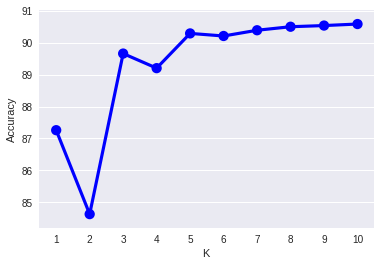

In [41]:
sns.pointplot(x = list(range(1,11)),y=list(cv.values()),color ='blue')
plt.xlabel(" K ")
plt.ylabel("Accuracy")

We observe that K = 10 is giving the highest accuracy from the CV. 

k = [6,7,8,9] are also giving almost similar accuracies with minute differences in decimals. 

The optimal K for the test  data can be confirmed after looking at the test accuracies of  K respectively in order to get the idea of the marginal differences between different K (6:10)

** TEST ACCURACIES **

In [46]:
for i in range(6,11):
  knn = KNeighborsClassifier(algorithm = 'kd_tree',n_neighbors=i,n_jobs=-1)
  knn.fit(X_train,y_train)
  pred = knn.predict(X_test)
  val = accuracy_score(y_true = y_test,y_pred = pred)
  print("Accuracy K : " + str(i) + " on test dataset is : " + str(val))

Accuracy K : 6 on test dataset is : 0.8939225098577062
Accuracy K : 7 on test dataset is : 0.8964940853763073
Accuracy K : 8 on test dataset is : 0.8974798559917709
Accuracy K : 9 on test dataset is : 0.8976941539516544
Accuracy K : 10 on test dataset is : 0.8991942396708383


In [48]:
knn.n_neighbors #the last fitted K = 10 and that is the best giving the highest accuracy on test data = 89.91 % almost equal to the CV 

10

In [49]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       0.72      0.30      0.42      2876
          1       0.91      0.98      0.94     20456

avg / total       0.89      0.90      0.88     23332



** OPTIMAL K = 10 FOR AVERAGE WORD2VEC : DATA FROM 1999-2009 : 77K DATAPOINTS ** <br>
** TEST ACCURACY = 0.899 **

<br>


## TFIDF WORD2VEC